# Introduction to the Dataset
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which I will be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. 

Here's what the first five rows look like:

In [1]:
import pandas as pd
bike_rentals = pd.read_csv("C:/Users/Jennifer/Documents/Python/Data/bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

instant - A unique sequential ID number for each row
dteday - The date of the rentals
season - The season in which the rentals occurred
yr - The year the rentals occurred
mnth - The month the rentals occurred
hr - The hour the rentals occurred
holiday - Whether or not the day was a holiday
weekday - Whether or not the day was a weekday
workingday - Whether or not the day was a working day
weathersit - The weather (as a categorical variable)
temp - The temperature, on a 0-1 scale
atemp - The adjusted temperature
hum - The humidity, on a 0-1 scale
windspeed - The wind speed, on a 0-1 scale
casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
registered - The number of registered riders (people who had already signed up)
cnt - The total number of bike rentals (casual + registered)

In this project, I will try to predict the total number of bikes people rented in a given hour. I will predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, I will create a few different machine learning models and evaluate their performance.

# Calculating Features
It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

(array([ 6972.,  3705.,  2659.,  1660.,   987.,   663.,   369.,   188.,
          139.,    37.]),
 array([   1. ,   98.6,  196.2,  293.8,  391.4,  489. ,  586.6,  684.2,
         781.8,  879.4,  977. ]),
 <a list of 10 Patch objects>)

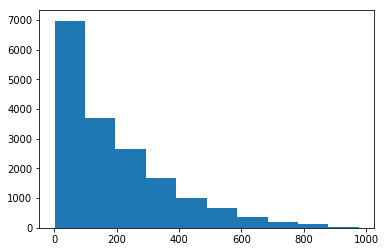

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(bike_rentals["cnt"])

In [3]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [4]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

# Splitting Data to Train/Test
Before we can begin applying machine learning algorithms, we need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If you train an algorithm on the training data, then evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.
This line will generate a Boolean series that's False when a row in bike_rentals isn't found in train: 
bike_rentals.index.isin(train.index)
This line will select any rows in bike_rentals that aren't found in train to be in the testing set: 
bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [5]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print(train.shape,test.shape)

(13903, 18) (3476, 18)


# Applying Linear Regression
Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

As you learned in earlier missions, linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

I am going to ignore the casual and registered columns because cnt is derived from them. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

In [6]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
import numpy
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

17244.193458409598

# Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

# Applying Decision Trees
Now we're ready to apply the decision tree algorithm. We will be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [9]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [10]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2549.6875014627626

In [11]:

reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2850.9585011507479

# Applying Random Forest
We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [12]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)


1887.9292132704068

# Conclusion
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.